In [5]:
import random
import pandas as pd
import numpy as np
from collections import Counter
import torch
from torch import nn
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from transformers import BertTokenizer
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report


In [6]:
# Hyperparameters
dataset_path       = "Cleaned_Tickets.csv"
seed                = 42
batch_size          = 32
val_batch_size      = 64
test_batch_size     = 64
max_length          = 256
embed_dim           = 256
hidden_dim          = 512
learning_rate       = 1e-3
patience            = 2
num_epochs          = 50
threshold_grid      = np.linspace(0.1, 0.9, 17)
p_dropout           = 0.1

In [ ]:
# Device & seeds
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():f
    torch.cuda.manual_seed_all(seed)

In [8]:
# Data loading & basic inspection
df = pd.read_csv(dataset_path)
print(f"Loaded {df.shape[0]} tickets with {df.shape[1]} columns")
print(df[['subject','body','tag_1','tag_2','tag_3']].isnull().sum(), "\n")

Loaded 16337 tickets with 9 columns
subject    0
body       0
tag_1      0
tag_2      0
tag_3      0
dtype: int64 



In [9]:
# Text & tag preprocessing
df['text'] = df['subject'].str.strip() + " " + df['body'].str.strip()
df['tags_list'] = df[['tag_1','tag_2','tag_3']].values.tolist()

In [10]:
# Build tag vocabulary
all_tag_lists = df['tags_list'].tolist()
unique_tags = sorted({tag for tags in all_tag_lists for tag in tags})

In [11]:
# Binarizer
mlb = MultiLabelBinarizer(classes=unique_tags)
mlb.fit(all_tag_lists)

,classes,"['AI', 'API', ...]"
,sparse_output,False


In [12]:
# Train/Val/Test split
texts = df['text'].tolist()
tag_lists = df['tags_list'].tolist()

X_temp, X_test, y_temp, y_test = train_test_split(
    texts, tag_lists, test_size=0.10, random_state=seed, shuffle=True
)
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=0.10, random_state=seed, shuffle=True
)

In [13]:
# Keep original lists for sampling
raw_y_train, raw_y_val, raw_y_test = y_train, y_val, y_test

In [14]:
# Binarize labels
y_train = mlb.transform(raw_y_train)
y_val   = mlb.transform(raw_y_val)
y_test  = mlb.transform(raw_y_test)

In [15]:
# Dataset
class TagDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256):
        self.texts      = texts
        self.labels     = labels
        self.tokenizer  = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        enc = self.tokenizer(
            self.texts[idx],
            padding="max_length",
            truncation=True,
            max_length=self.max_length,
            return_attention_mask=True,
            return_tensors="pt"
        )
        return {
            "input_ids":      enc["input_ids"].squeeze(0),
            "attention_mask": enc["attention_mask"].squeeze(0),
            "labels":         torch.tensor(self.labels[idx], dtype=torch.float)
        }

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

train_ds = TagDataset(X_train, y_train, tokenizer, max_length)
val_ds   = TagDataset(X_val,   y_val,   tokenizer, max_length)
test_ds  = TagDataset(X_test,  y_test,  tokenizer, max_length)

In [16]:
# Sampler for rare tags
flat_tags      = [t for tags in raw_y_train for t in tags]
tag_freq       = Counter(flat_tags)
inv_freq       = {t: 1.0/count for t, count in tag_freq.items()}
sample_weights = [sum(inv_freq[t] for t in tags) for tags in raw_y_train]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

In [17]:
# DataLoaders
train_loader = DataLoader(
    train_ds, batch_size=batch_size,
    sampler=sampler, num_workers=0, pin_memory=True
)
val_loader = DataLoader(
    val_ds,   batch_size=val_batch_size,
    shuffle=False, num_workers=0
)
test_loader = DataLoader(
    test_ds,  batch_size=test_batch_size,
    shuffle=False, num_workers=0
)

In [18]:
# Model definition
class TagClassifier(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_tags, p_dropout):
        super().__init__()
        self.embed      = nn.Embedding(vocab_size, embed_dim, padding_idx=0)
        self.fc1        = nn.Linear(embed_dim, hidden_dim)
        self.relu       = nn.ReLU()
        self.dropout1   = nn.Dropout(p_dropout)      # <— new
        self.classifier = nn.Linear(hidden_dim, num_tags)

    def forward(self, input_ids, attention_mask):
        x      = self.embed(input_ids) * attention_mask.unsqueeze(-1)
        summed = x.sum(dim=1)
        cnts   = attention_mask.sum(dim=1, keepdim=True).clamp(min=1)
        avg    = summed / cnts
        h      = self.relu(self.fc1(avg))
        h      = self.dropout1(h)                    # <— apply dropout here
        out    = self.classifier(h)
        return out

model = TagClassifier(
    vocab_size=tokenizer.vocab_size,
    embed_dim=embed_dim,
    hidden_dim=hidden_dim,
    num_tags=len(unique_tags),
    p_dropout=p_dropout
).to(device)

In [19]:
# Optimizer & Loss
optimizer = AdamW(model.parameters(), lr=1e-3)
scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',           # we monitor F1, so “max”
    factor=0.5,           # multiply LR by 0.5 on plateau
    patience=2,           # wait 2 epochs with no improvement
    threshold=1e-4        # “significant” improvement threshold
)
loss_fn   = nn.BCEWithLogitsLoss()

In [20]:
# Training & Eval Helpers
class EarlyStopping:
    def __init__(self, patience=patience, mode="max", delta=0.0):
        self.patience   = patience
        self.mode       = mode
        self.delta      = delta
        self.best       = None
        self.bad_epochs = 0
        self.should_stop= False

    def step(self, metric):
        if self.best is None:
            self.best = metric
            return
        improved = (metric > self.best + self.delta) if self.mode=="max" \
                   else (metric < self.best - self.delta)
        if improved:
            self.best = metric
            self.bad_epochs = 0
        else:
            self.bad_epochs += 1
            if self.bad_epochs >= self.patience:
                self.should_stop = True

def train_epoch():
    model.train()
    total_loss = 0.0
    for batch in train_loader:
        ids, mask, labs = (
            batch["input_ids"].to(device),
            batch["attention_mask"].to(device),
            batch["labels"].to(device)
        )
        optimizer.zero_grad()
        logits = model(ids, mask)
        loss   = loss_fn(logits, labs)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

def eval_loader(loader, thresholds=0.5):
    model.eval()
    all_logits, all_true = [], []
    total_loss = 0.0
    n_batches = 0

    with torch.no_grad():
        for batch in loader:
            ids   = batch["input_ids"].to(device)
            mask  = batch["attention_mask"].to(device)
            labs  = batch["labels"].to(device)

            logits = model(ids, mask)
            loss   = loss_fn(logits, labs)
            total_loss += loss.item()
            n_batches  += 1

            all_logits.append(logits.cpu().numpy())
            all_true.append(labs.cpu().numpy())

    # stack into arrays
    avg_loss = total_loss / n_batches
    logits   = np.vstack(all_logits)   # [N, num_tags]
    y_true   = np.vstack(all_true)     # [N, num_tags]

    # apply sigmoid + thresholds
    probs    = 1.0 / (1.0 + np.exp(-logits))
    if isinstance(thresholds, (float,int)):
        y_pred = (probs > thresholds).astype(int)
    else:
        # per-tag thresholds
        y_pred = np.stack([
            (probs[:,i] > thresholds[i]).astype(int)
            for i in range(probs.shape[1])
        ], axis=1)

    # compute micro metrics
    micro_p = precision_score(y_true, y_pred, average="micro", zero_division=0)
    micro_r = recall_score   (y_true, y_pred, average="micro", zero_division=0)
    micro_f = f1_score       (y_true, y_pred, average="micro", zero_division=0)
    # compute macro-F1
    macro_f = f1_score       (y_true, y_pred, average="macro", zero_division=0)

    return {
        "loss":      avg_loss,
        "precision": micro_p,
        "recall":    micro_r,
        "f1":        micro_f,
        "macro_f1":  macro_f,
        "y_true":    y_true,
        "y_pred":    y_pred
    }

def tune_thresholds(val_logits, val_true):
    best_thresh = []
    for i in range(val_true.shape[1]):
        best_f1, best_t = 0, 0.5
        for t in threshold_grid:
            preds_i = (1/(1+np.exp(-val_logits[:,i])) > t).astype(int)
            f1 = f1_score(val_true[:,i], preds_i, zero_division=0)
            if f1 > best_f1:
                best_f1, best_t = f1, t
        best_thresh.append(best_t)
    return np.array(best_thresh)

In [21]:
# Training Loop
best_f1       = -float("inf")
checkpoint    = "baseline_tags_model_weights.pt"
early_stopper = EarlyStopping()
train_losses, val_losses = [], []
val_f1s = []

for epoch in range(1, num_epochs+1):
    print(f"\n→ Epoch {epoch}", flush=True)

    # 1) training
    tr_loss = train_epoch()
    train_losses.append(tr_loss)

    # 2) validation
    val_res = eval_loader(val_loader)
    val_losses.append(val_res['loss'])
    val_f1s.append(val_res['f1'])

    # 3) scheduler on val-F1
    scheduler.step(val_res["f1"])

    # 4) checkpoint
    if val_res["f1"] > best_f1:
        best_f1 = val_res["f1"]
        torch.save(model.state_dict(), checkpoint)
        print(f"  New best Val F1={best_f1:.4f}, checkpoint saved.")

    # 5) log
    print(
        f"  Train Loss: {tr_loss:.4f} | "
        f"Val Loss:   {val_res['loss']:.4f} | "
        f"Val F1:     {val_res['f1']:.4f} | "
        f"P: {val_res['precision']:.4f} | R: {val_res['recall']:.4f}"
    )

    # 6) early stop
    early_stopper.step(val_res["f1"])
    if early_stopper.should_stop:
        print("Early stopping triggered.")
        break



→ Epoch 1
  New best Val F1=0.2005, checkpoint saved.
  Train Loss: 0.0540 | Val Loss:   0.0259 | Val F1:     0.2005 | P: 0.8195 | R: 0.1142

→ Epoch 2
  New best Val F1=0.3243, checkpoint saved.
  Train Loss: 0.0194 | Val Loss:   0.0247 | Val F1:     0.3243 | P: 0.7780 | R: 0.2048

→ Epoch 3
  New best Val F1=0.4186, checkpoint saved.
  Train Loss: 0.0120 | Val Loss:   0.0232 | Val F1:     0.4186 | P: 0.7565 | R: 0.2894

→ Epoch 4
  New best Val F1=0.4538, checkpoint saved.
  Train Loss: 0.0087 | Val Loss:   0.0228 | Val F1:     0.4538 | P: 0.7670 | R: 0.3222

→ Epoch 5
  New best Val F1=0.4955, checkpoint saved.
  Train Loss: 0.0066 | Val Loss:   0.0218 | Val F1:     0.4955 | P: 0.7591 | R: 0.3678

→ Epoch 6
  New best Val F1=0.5160, checkpoint saved.
  Train Loss: 0.0055 | Val Loss:   0.0215 | Val F1:     0.5160 | P: 0.7473 | R: 0.3941

→ Epoch 7
  New best Val F1=0.5451, checkpoint saved.
  Train Loss: 0.0046 | Val Loss:   0.0205 | Val F1:     0.5451 | P: 0.7372 | R: 0.4324

→ Epo

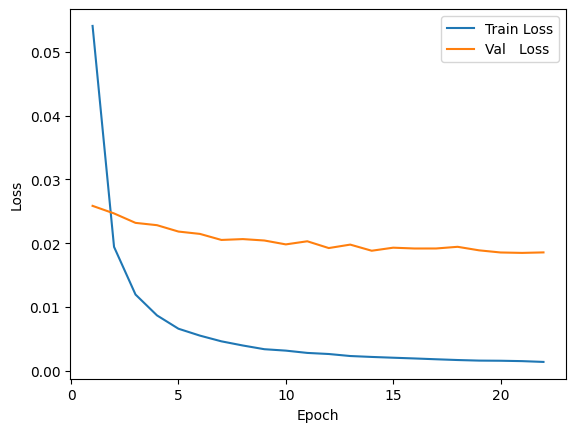

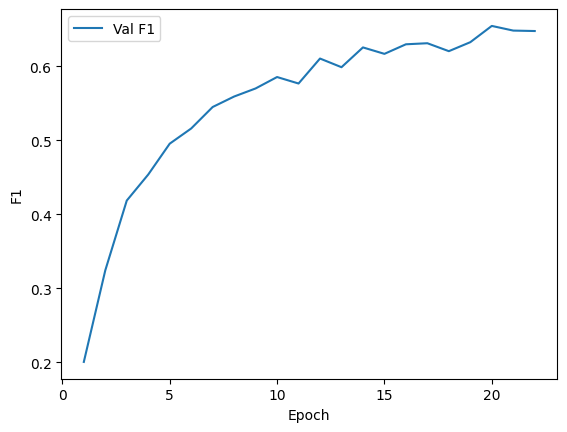

In [22]:
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Loss
plt.plot(range(1, len(train_losses)+1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses)+1),   val_losses,   label="Val   Loss")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.show()

# F1
plt.plot(range(1, len(val_f1s)+1), val_f1s, label="Val F1")
plt.xlabel("Epoch"); plt.ylabel("F1"); plt.legend(); plt.show()



In [23]:
# Tune Thresholds on Validation
# Collect val logits & truths
val_logits, val_true = [], []
model.load_state_dict(torch.load(checkpoint, map_location=device))
model.eval()
with torch.no_grad():
    for batch in val_loader:
        out = model(batch["input_ids"].to(device),
                    batch["attention_mask"].to(device)).cpu().numpy()
        val_logits.append(out)
        val_true.append(batch["labels"].cpu().numpy())
val_logits = np.vstack(val_logits)
val_true   = np.vstack(val_true)

best_thresh = tune_thresholds(val_logits, val_true)
print("Per-tag thresholds:", best_thresh)

Per-tag thresholds: [0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.35 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.6  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.1  0.5
 0.5  0.5  0.5  0.4  0.5  0.1  0.1  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.25 0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.3  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.8  0.1  0.5
 0.5  0.85 0.5  0.5  0.5  0.5  0.5  0.5  0.35 0.5  0.5  0.5  0.2  0.5
 0.5  0.1  0.5  0.5  0.5  0.4  0.1  0.5  0.5  0.5  0.35 0.5  0.5  0.5
 0.5  0.5  0.45 0.5  0.5  0.5  0.1  0.5  0.15 0.5  0.5  0.5  0.5  0.5
 0.5  0.5  0.5  0.5  0.3  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5  0.5
 0.5  0.1  0.5  0.5  0.85 0.5  0.5  0.5  0.5  0.1  0.5  0.5  0.2  0.1
 0.5  0.5  0.2  0.5  0.5  0.5  0.1  0.5  0.5  0.5  0.65 0.5  0.1  0.5
 0.5  0.5  0.5  0.5  0.35 0.35 0.5  0.5  0.5  0.1  0.5  0.5  0.5  0.5
 0.5  0.5  0.55 0.5  0.5  0.5  0.1  0.5  0.2  0.5  0.5  0.5  0.9  0.5
 0.5  0.5  0.5  0.5  0.5  0.1  0.5  0.5  0.5  0.5  0.5  0.1  0.5  0.5


In [24]:
# Final Test Evaluation
test_res = eval_loader(test_loader, thresholds=best_thresh)

print("\n--- Test Results with tuned thresholds ---")
print(f"Precision: {test_res['precision']:.4f}")
print(f"Recall   : {test_res['recall']:.4f}")
print(f"Micro F1 : {test_res['f1']:.4f}")
print(f"Macro F1 : {test_res['macro_f1']:.4f}\n")

# full per-tag report on the original tag space
print("Per-tag performance:")
print(classification_report(
    test_res['y_true'],    # these should be your final y_true_orig if you mapped back
    test_res['y_pred'],    # likewise y_pred_orig
    target_names=mlb.classes_,
    zero_division=0
))


--- Test Results with tuned thresholds ---
Precision: 0.6336
Recall   : 0.6669
Micro F1 : 0.6498
Macro F1 : 0.1164

Per-tag performance:
                           precision    recall  f1-score   support

                       AI       0.00      0.00      0.00         0
                      API       0.00      0.00      0.00         0
          API Integration       0.00      0.00      0.00         0
                      AWS       0.00      0.00      0.00         0
                   Access       0.00      0.00      0.00         1
           Access Control       0.00      0.00      0.00         0
        Access Management       0.00      0.00      0.00         1
            Accessibility       0.00      0.00      0.00         0
                  Account       0.79      0.47      0.59        32
                 Accuracy       1.00      1.00      1.00         1
           ActiveCampaign       0.00      0.00      0.00         1
               Adjustment       0.00      0.00      0.00 